## **IV. Xây dựng mô hình (Data Modeling)**

### 1. Chuẩn bị dữ liệu

**Thêm các thư viện cần thiết**

In [73]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import  mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import random


**Đọc dữ liệu lên từ tập dữ liệu**

In [45]:
# Đọc dữ liệu lên từ tập cleaned_data.csv
data = pd.read_csv("cleaned_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            9327 non-null   float64
 1   Area             9327 non-null   float64
 2   Bedrooms         9327 non-null   int64  
 3   Toilets          9327 non-null   int64  
 4   Published At     9327 non-null   object 
 5   Developer        9327 non-null   object 
 6   Street           9327 non-null   object 
 7   District         9327 non-null   object 
 8   Suggested Price  9327 non-null   float64
 9   Million/m2       9327 non-null   float64
 10  District Price   9327 non-null   float64
 11  Street Price     9327 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 874.5+ KB


**Nhận xét**: 
- Có tộng cộng **9327** **dòng** và **12 thuộc tính** trong tập dữ liệu.

- Dữ liệu có chứa nhiều thuộc tính với nhiều loại khác nhau.

- Các thuộc tính cần thiết cho việc xây dựng mô hình đã được chuẩn hóa sang dữ liệu `number`.

- Nên chúng ta có thể dễ dàng chọn các thuộc tính cần thiết thông qua `select_dtypes`.

**Cột dữ liệu mục tiêu được tách ra khỏi tập dữ liệu ban đầu**

In [46]:
# Chỉ lấy các thuộc tính dạng số 
X = data.select_dtypes(include=["number"]).drop(columns=["Price"])

# Chọn thuộc tính mục tiêu
y = data['Price']

**Chia dữ liệu ra tập train và tập test**

Dữ liệu sẽ được chia ra với tỷ lệ 80% tập train và 20% tập test

In [47]:
# Chia dữ liệu thành 80% train và 20% test thông qua việc điều chỉnh tham số test_size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Khởi tạo mô hình

**Định nghĩa hàm đánh giá MAE**

In [48]:
def evaluate_model(model, X, y):
    neg_mae_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    mae_scores = -neg_mae_scores
    return mae_scores.mean()

**Định nghĩa hàm kiểm thử**

In [49]:
def check_with_model(X_test, y_test, model):
    # Lấy một chỉ số ngẫu nhiên từ tập kiểm thử
    random_index = np.random.randint(0, len(X_test))

    # Lấy giá trị thử nghiệm từ X_test
    X_sample = X_test.iloc[random_index].values.reshape(1, -1)

    # Hiển thị giá trị thử nghiệm
    print("Giá trị thử nghiệm (X_sample):")
    print(X_sample)

    # Dự đoán giá trị y tương ứng cho X_sample
    y_pred_sample = model.predict(X_sample)

    # Hiển thị giá trị dự đoán và giá trị thực tế từ y_test
    print(f"\nGiá trị thực tế (y_test[{random_index}]): {y_test.iloc[random_index]}")
    print(f"Giá trị dự đoán: {y_pred_sample[0]}")

#### **a. Khởi tạo mô hình cơ bản - Linear Regression**

**Khởi tạo mô hình Linear Regression**

In [50]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

**Đánh giá mô hình cơ bản bằng Cross-Valid**

In [51]:
# Định nghĩa k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [52]:
# Đánh giá mô hình bằng cross-validation
cv_results = cross_val_score(linear_model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# In kết quả
print(f"Mean Squared Error (MAE) for each fold: {-cv_results}")
print(f"Average MSE across 5 folds: {-cv_results.mean()}")

Mean Squared Error (MAE) for each fold: [3.32420985 3.65701232 3.89150833 3.70831037 3.5432473 ]
Average MSE across 5 folds: 3.6248576330804525


**Nhận xét**:
- Mô hình cho ra MAE khá cao, tới 3.62

**Xác định công thức hồi quy tuyến tính**

In [53]:
# Lấy các tham số trả về từ mô hình
coefficients = linear_model.coef_
intercept = linear_model.intercept_

# Công thức hồi quy 
regression_formula = f"Price = {intercept:.3f} + " + " + ".join([f"({coeff:.3f})*{feature}" for coeff, feature in zip(coefficients, X_train.columns)])
regression_formula

'Price = -13.480 + (0.118)*Area + (0.244)*Bedrooms + (0.375)*Toilets + (0.005)*Suggested Price + (0.057)*Million/m2 + (0.144)*District Price + (0.304)*Street Price'

**Nhận xét**
- Mô hình hồi quy khá phức tạp, chúng ta sẽ đơn giản hóa nó bằng cách loaị bỏ các thuộc tính không quan trọng

**Sử dụng Lasso Regression để loại bỏ các thuộc tính không quan trọng**

In [54]:
# Xây dựng mô hình Lasso Regression
lasso = Lasso(alpha=0.1)  # alpha là tham số điều chỉnh độ mạnh của regularization
lasso.fit(X_train, y_train)

# Lấy các hệ số hồi quy
lasso_coefficients = lasso.coef_

# Loại bỏ các thuộc tính có hệ số bằng 0
selected_features = [feature for feature, coef in zip(X_train.columns, lasso_coefficients) if coef != 0]

print("Các đặc trưng được chọn: ", selected_features)

Các đặc trưng được chọn:  ['Area', 'Bedrooms', 'Toilets', 'Suggested Price', 'Million/m2', 'District Price', 'Street Price']


In [55]:
# Lấy các hệ số của Lasso sau khi loại bỏ thuộc tính không quan trọng
lasso_coefficients = lasso.coef_

# Cập nhật công thức hồi quy, chỉ giữ lại các thuộc tính quan trọng
regression_formula = f"Price = {intercept:.3f} + " + " + ".join([f"({coeff:.3f})*{feature}" 
                                                           for coeff, feature in zip(lasso_coefficients, X_train.columns) 
                                                           if coeff != 0])

print("Công thức hồi quy: ", regression_formula)


Công thức hồi quy:  Price = -13.480 + (0.119)*Area + (0.214)*Bedrooms + (0.367)*Toilets + (0.006)*Suggested Price + (0.058)*Million/m2 + (0.135)*District Price + (0.304)*Street Price


**Sử dụng thêm Statsmodel để phân tích ý nghĩa thống kê**

In [56]:
# Thêm cột intercept (hằng số) vào dữ liệu X_train
X_train_with_intercept = sm.add_constant(X_train)

# Xây dựng mô hình hồi quy tuyến tính
model = sm.OLS(y_train, X_train_with_intercept).fit()

# Lấy kết quả tóm tắt của mô hình
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     4336.
Date:                Sat, 04 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:31:54   Log-Likelihood:                -24718.
No. Observations:                7461   AIC:                         4.945e+04
Df Residuals:                    7453   BIC:                         4.951e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -13.4800      0.234    -

**Nhận xét**:
- Tất cả các thuộc tính đều mang ý nghĩa thống kê (P-value < 0.05), do đó việc loại bỏ các thuộc tính là không cần thiết.

**Thử lấy một mẫu ngẫu nhiên để kiểm tra mô hình**

In [57]:
check_with_model(X_test, y_test, linear_model)

Giá trị thử nghiệm (X_sample):
[[56.     3.     2.    77.1   80.36   5.225  4.1  ]]

Giá trị thực tế (y_test[1307]): 4.5
Giá trị dự đoán: 1.6366882130750735


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


#### **b. Khởi tạo các mô hình khác**

**Khởi tạo mô hình**

In [58]:
decision_tree = DecisionTreeRegressor(random_state=42)
random_forest = RandomForestRegressor(random_state=42, n_estimators=100)
xgboost = XGBRegressor(random_state=42, n_estimators=100)

In [59]:
# Đánh giá từng mô hình
models = {
    "Linear Regression": linear_model,
    "Decision Tree": decision_tree,
    "Random Forest": random_forest,
    "XGBoost": xgboost
}

### 3. Đánh giá từng mô hình thông qua Cross-Valid

In [60]:
results = {}
for model_name, model in models.items():
    mae = evaluate_model(model, X_train, y_train)
    results[model_name] = mae
    print(f"{model_name}: Mean Absolute Error (MAE) = {mae:.3f}")

Linear Regression: Mean Absolute Error (MAE) = 3.625


Decision Tree: Mean Absolute Error (MAE) = 0.528
Random Forest: Mean Absolute Error (MAE) = 0.261
XGBoost: Mean Absolute Error (MAE) = 0.392


**Nhận xét**:
- Thông qua phương pháp Cross-valid thì Random Forest cho ra kết quả khả quan nhấ với chỉ 0.261, tốt hơn rất nhiều so với mô hình cơ bản ban đầu

### 4. So sánh các mô hình với nhau

**Huấn luyện các mô hình**

In [68]:
# Huấn luyện tất cả các mô hình
for model_name, model in models.items():
    model.fit(X_train, y_train)  

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)
    
    # Tính MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    # Tính R²
    r2 = r2_score(y_test, y_pred)
    
    # In kết quả đánh giá
    print(f"Model: {model_name}")
    print(f"  MAE = {mae:.3f}")
    print(f"  R² = {r2:.3f}")
    print("-" * 30)


Model: Linear Regression
  MAE = 3.523
  R² = 0.846
------------------------------
Model: Decision Tree
  MAE = 0.431
  R² = 0.994
------------------------------
Model: Random Forest
  MAE = 0.227
  R² = 0.997
------------------------------
Model: XGBoost
  MAE = 0.403
  R² = 0.991
------------------------------


**Nhận xét**:
- So sánh bằng `MAE`:

    - Xét về thông số `MAE Random Forest` và `XGBoost` là hai mô hình cho ra kết quả chính xác nhất lần lượt là **0.261** và **0.392**
    - Mô hình còn lại là `Decision Tree` chỉ cho ra `MAE` khoảng **0.53**
    - Tuy vậy cả 3 mô hình đều cho ra kết quả rất tốt khi đem so sánh với mô hình cơ bản ban đầu
- So sánh bằng `R2`: tương tự `MAE`

    - `Random Forest` (R² = 0.996):

        - Đây là mô hình tốt nhất trong số các mô hình được thử nghiệm.
        - Mức độ phù hợp rất cao, gần như toàn bộ phương sai của dữ liệu được giải thích bởi mô hình.
        - `Random Forest` có khả năng xử lý tốt dữ liệu phi tuyến và giảm overfitting nhờ cơ chế trung bình của nhiều cây.

    - `XGBoost` (R² = 0.995):

        - Hiệu suất tương đương với `Random Forest`, chỉ chênh lệch rất nhỏ.
        - `XGBoost` nổi tiếng với khả năng tối ưu hóa hiệu suất và xử lý tốt dữ liệu phức tạp.
        - `Decision Tree` (R² = 0.991):

    - Hiệu suất tốt nhưng thấp hơn `Random Forest` và `XGBoost`.
        - `Decision Tree` dễ bị **overfitting** trên dữ liệu huấn luyện, nhưng vẫn là một mô hình đáng cân nhắc cho dữ liệu nhỏ hoặc khi cần diễn giải trực quan.
    - `Linear Regression` (R² = 0.737):

        - Hiệu suất thấp hơn đáng kể so với các mô hình phi tuyến.
        - Điều này cho thấy dữ liệu có thể chứa mối quan hệ phi tuyến giữa các đặc trưng và biến mục tiêu, làm cho mô hình tuyến tính không phù hợp.


### 5. Trực quan hóa kết quả

##### **Một số biểu đồ so sánh kết quả**


**Biểu đồ giá trị thực và dự đoán**

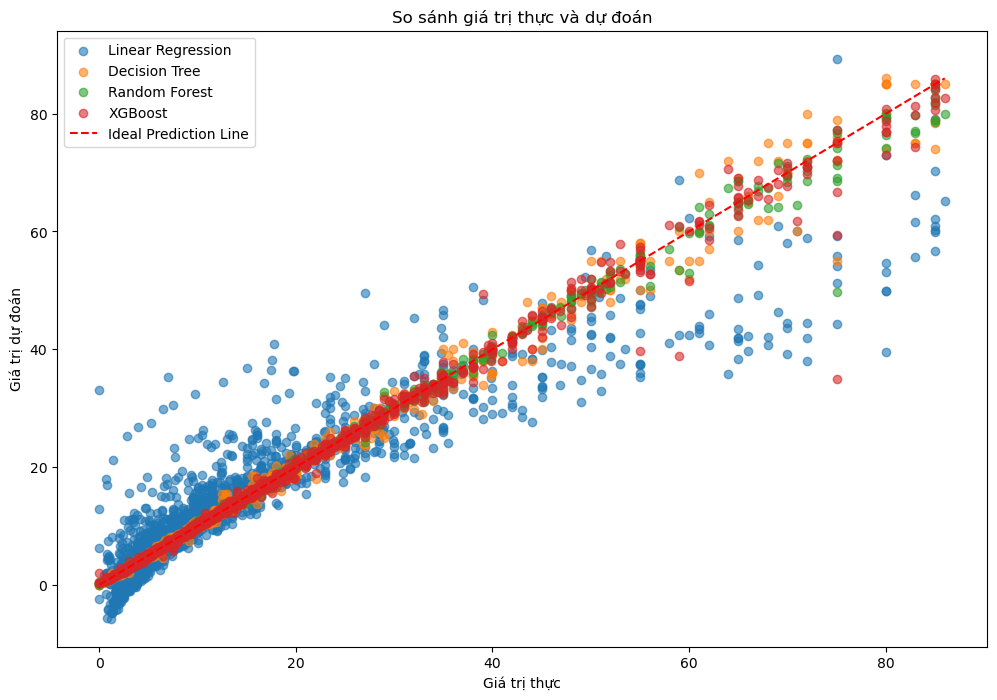

In [70]:
# Dự đoán cho từng mô hình
predictions = {
    "Linear Regression": models["Linear Regression"].predict(X_test),
    "Decision Tree": models["Decision Tree"].predict(X_test),
    "Random Forest": models["Random Forest"].predict(X_test),
    "XGBoost": models["XGBoost"].predict(X_test),
}

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
for model_name, y_pred in predictions.items():
    plt.scatter(y_test, y_pred, label=model_name, alpha=0.6)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction Line')
plt.xlabel('Giá trị thực')
plt.ylabel('Giá trị dự đoán')
plt.title('So sánh giá trị thực và dự đoán')
plt.legend()
plt.show()

**Nhận xét**:

- Random Forest và XGBoost cho thấy sự hội tụ khá cao, chứng tỏ mô hình dự đoán rất chính xác

- Linear Regression nhận thấy sự phân tán rõ rệt trong giữ liệu, không hội tụ như các mô hình khác.

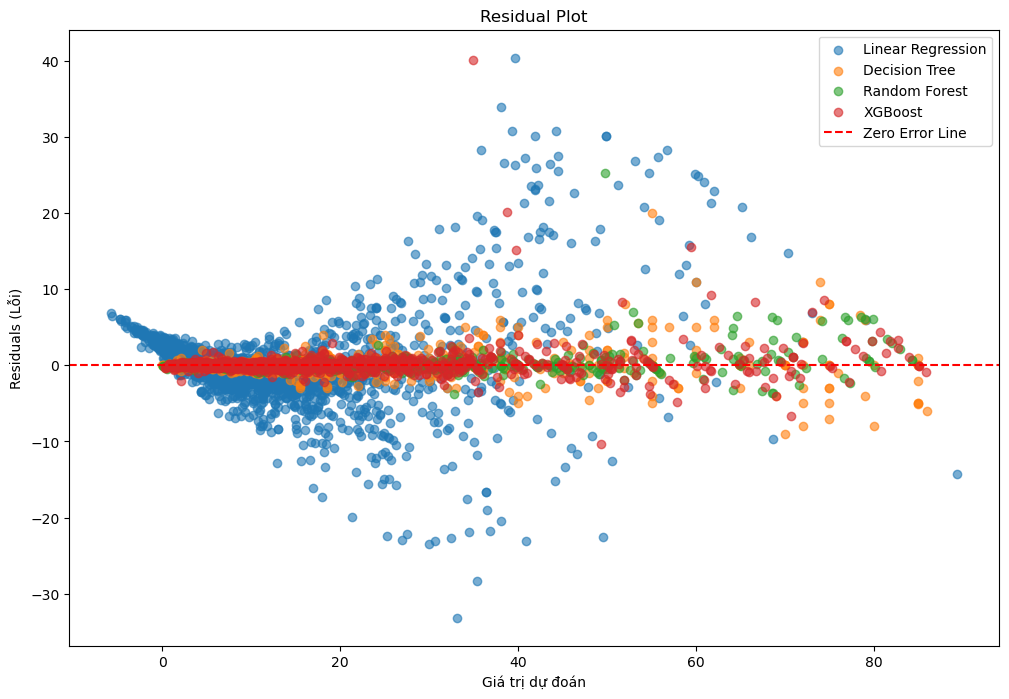

In [71]:
plt.figure(figsize=(12, 8))
for model_name, y_pred in predictions.items():
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, label=model_name, alpha=0.6)

plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Giá trị dự đoán')
plt.ylabel('Residuals (Lỗi)')
plt.title('Residual Plot')
plt.legend()
plt.show()


**Nhận xét**:
- Biểu đồ lỗi cũng cho ra kết quả tương tự với biểu đồ Linear 

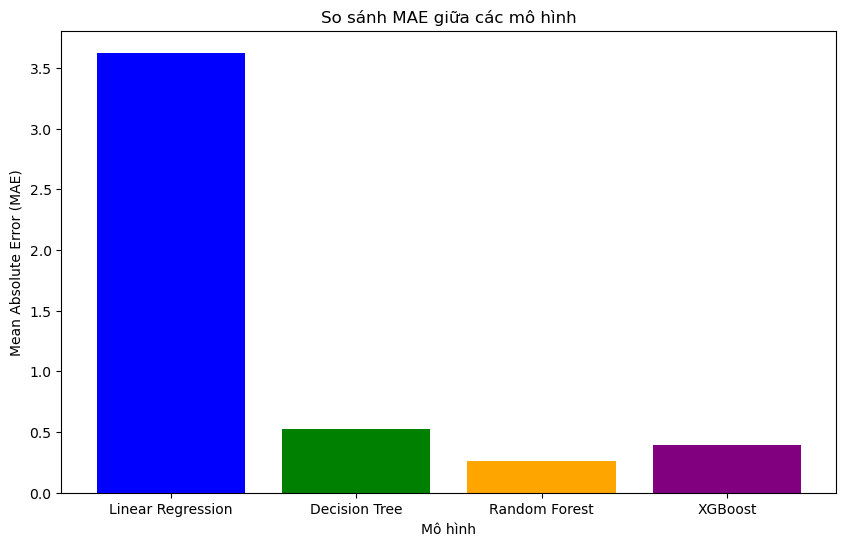

In [72]:
mae_results = {
    "Linear Regression": 3.625,
    "Decision Tree": 0.528,
    "Random Forest": 0.261,
    "XGBoost": 0.392
}

plt.figure(figsize=(10, 6))
plt.bar(mae_results.keys(), mae_results.values(), color=['blue', 'green', 'orange', 'purple'])
plt.xlabel('Mô hình')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('So sánh MAE giữa các mô hình')
plt.show()


**Nhận xét**
- Biểu đồ này giúp chúng ta nhận thấy được sư khác biệt về độ chính xác giữa các biểu đồ, thông số càng thấp chỉ số chính xác càng cao

##### **Lấy thử một giá trị ngẫu nhiên sau đó đem đi dự đoán và so sánh với gía trị thực**

**Chọn lấy một giá trị ngẫu nhiên trong tập test**

In [78]:
# Chọn chỉ số ngẫu nhiên trong tập kiểm tra
random_index = random.randint(0, len(X_test) - 1)

# Lấy mẫu ngẫu nhiên từ tập kiểm tra
sample_X = X_test.iloc[random_index].to_numpy().reshape(1, -1)  # Chuyển Series thành NumPy array và reshape
sample_y = y_test.iloc[random_index]

# Hiển thị mẫu đã chọn
print("Sample Features:", sample_X)
print("Actual Value:", sample_y)

Sample Features: [[ 68.3    5.     6.   175.6  161.05  11.5   20.3 ]]
Actual Value: 11.0


**Dự đoán bằng 4 mô hình khác nhau**


In [96]:
# Dự đoán giá trị cho mẫu ngẫu nhiên
predictions = {}
for model_name, model in models.items():
    predictions[model_name] = model.predict(sample_X)[0]

print("Actual Value:", sample_y)

# In các dự đoán
for model_name, prediction in predictions.items():
    print(f"{model_name} Prediction: {prediction:.3f}")


Actual Value: 11.0
Linear Regression Prediction: 16.041
Decision Tree Prediction: 11.000
Random Forest Prediction: 10.977
XGBoost Prediction: 11.086


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


**Nhận xét**:
- Với mẫu dữ liệu [ 68.3, 5, 6, 175.6, 161.05, 11.5, 20.3 ], giá trị Tartget thực: 11.0 thì Decision Tree cho ra kết quả hoàn toàn trùng khớp với giá trị thực, cho thấy cả 3 mô hình được lựa chọn đều mạnh mẽ và chính xác